# Exercise-4.5

> Cancer deaths: Suppose for a set of counties $i \in \{1, ... , n\}$ we have information on the population size $X_i$ = number of people in 10'000s, and $Y_i$ = number of cancer fatalities. One model for the distribution of cancer fatalities is that, given the cancer rate $\theta$, they are independently distributed with $Y_i \sim Poisson(\theta \cdot X_i)$.

In [1]:
options(repr.plot.width=10, repr.plot.height=4)
library(ggplot2)

cancer_react <- read.table(
    "http://www.stat.washington.edu/people/pdhoff/Book/Data/hwdata/cancer_react.dat",
    header=TRUE)
cancer_noreact <- read.table(
    "http://www.stat.washington.edu/people/pdhoff/Book/Data/hwdata/cancer_noreact.dat",
    header=TRUE)

##### Problem A

> a) Identify the posterior distribution of $\theta$ given data $(Y_1, X_1), ... ,(Y_n, X_n)$ and a $gamma(a, b)$ prior distribution. The file `cancer_react.dat` contains 1990 population sizes (in 10'000s) and number of cancer fatalities for 10 counties in a Midwestern state that are near nuclear reactors. The file `cancer_noreact.dat` contains the same data on counties in the same state that are not near nuclear reactors. Consider these data as samples from two populations of counties: one is the population of counties with no neighboring reactors and a fatality rate of $\theta_1$ deaths per 10'000, and the other is a population of counties having nearby reactors and a fatality rate of $\theta_2$. In this exercise we will model beliefs about the rates as independent and such that $\theta_1 \sim gamma(a_1, b_1)$ and $\theta_2 \sim gamma(a_2, b_2)$.

##### Solution

Prior is a Gamma:

$$
p(\theta|a, b) = Gamma(\theta | a, b) = \frac{b^a}{\Gamma(a)}\cdot \theta^{a-1} \cdot e^{-b\theta}
$$

Likelihood is a Poisson:

$$
\begin{align}
p(y_i|\theta \cdot x_i) &= Poisson(y_i | \theta \cdot x_i) = \frac{(\theta x_i)^{y_i} \cdot e^{-\theta x_i}}{y_i!}\\
p(y|\theta \cdot x) &= \prod_{i=1}^{n} Poisson(y_i | \theta \cdot x_i)\\
&= \prod_{i=1}^{n}\frac{(\theta x_i)^{y_i} \cdot e^{-\theta x_i}}{y_i!}\\
&= \prod_{i=1}^n\frac{{x_i}^{y_i}}{y_i!} \cdot \theta^{\sum_{i=1}^{n}y_i} \cdot e^{-\theta\sum_{i=1}^{n}x_i}
\end{align}
$$

Posterior distribution is a Gamma:

$$
\begin{align}
p(\theta|x, y, a,b) &= \frac{p(y|\theta \cdot x) \cdot p(\theta|a, b)}{p(y|\theta, x, a, b)}\\
&= \frac{p(y|\theta \cdot x) \cdot p(\theta|a, b)}{ \int_{0}^{+\infty}p(y, \theta| x, a, b) d\theta}\\
p(y|\theta \cdot x) \cdot p(\theta|a, b) &= \prod_{i=1}^n\frac{{x_i}^{y_i}}{y_i!} \cdot \frac{b^a}{\Gamma(a)} \cdot \theta^{(a + \sum_{i=1}^{n}y_i) - 1} \cdot e^{-\theta \cdot (b + \sum_{i=1}^{n}x_i)}\\
&= C \cdot \theta^{a_{post} - 1} \cdot e^{-\theta \cdot b_{post}}\\
a_{post} &= a + \sum_{i=1}^{n}y_i\\
b_{post} &= b + \sum_{i=1}^{n}x_i\\
p(θ|x,y,a,b) &= Gamma(\theta | a_{post}, b_{post})
\end{align}
$$

##### Problem B

> b) Using the numerical values of the data, identify the posterior distributions for $\theta_1$ and $\theta_2$ for any values of $(a_1, b_1, a_2, b_2)$.

##### Solution

Let's have a rough estimate of $\theta$:

In [2]:
round(c(
    sum(cancer_noreact$y)/sum(cancer_noreact$x),
    sum(cancer_react$y)/sum(cancer_react$x)), digits=1)

[1] 2.2 2.7

The function builds 2 posterior distributions with credible intervals:

In [3]:
build_plot <- function(a1, b1, a2, b2, xs=seq(1.5,3.5,0.1)) {
    a1_ <- a1 + sum(cancer_noreact$y)
    b1_ <- b1 + sum(cancer_noreact$x)
    a2_ <- a2 + sum(cancer_react$y)
    b2_ <- b2 + sum(cancer_react$x)
    ci <- function(x, a, b) {
        ci_ <- qgamma(c(0.025, 0.975), a, b)
        y <- dgamma(x, a, b)
        y[x < ci_[1] | ci_[2] < x] <- NA
        y
    }
    add_gamma <- function(p, a, b, color) {
        p + stat_function(fun=function(x) {
                dgamma(x, a, b)
            }, color=color, size=1, n=500) +
            stat_function(fun=function(x) { ci(x, a, b)}, geom='area', fill=color, alpha=0.2, n=500) +
            geom_vline(xintercept=a/b, linetype=3, show.legend=TRUE) +
            annotate("text", label = round(a/b, digits=1), x = a/b+0.05, y = -0.5, size = 3)
    }

    mc.n <- 10000
    print(mean(rgamma(mc.n, a1_, b1_) < rgamma(mc.n, a2_, b2_)))
    
    p <- ggplot(data.frame(theta=xs), aes(theta))
    p <- add_gamma(p, a1_, b1_, color='green')
    p <- add_gamma(p, a2_, b2_, color='red')
    p +  guides(fill = guide_legend(title = "LEFT", title.position = "left"))
}

##### Problem C

> c) Suppose cancer rates from previous years have been roughly $\overset{\sim}{\theta} = 2.2$ per 10'000 (and note that most counties are not near reactors). For each of the following three prior opinions, compute $\mathbb{E}[\theta_1\ |\ data]$, $\mathbb{E}[\theta_2\ |\ data]$, 95% quantile-based posterior intervals for $\theta_1$ and $\theta_2$, and $Pr(\theta_2 > \theta_1\ |\ data)$. Also plot the posterior densities (try to put $p(\theta_1\ |\ data)$ and $p(\theta_2\ |\ data)$ on the same plot). Comment on the differences across posterior opinions

>  - i. Opinion 1: $(a_1 = a_2 = 2.2 \times 100, b_1 = b_2 = 100)$. Cancer rates for both types of counties are similar to the average rates across all counties from previous years.

>  - ii. Opinion 2: $(a_1 = 2.2 \times 100, b_1 = 100, a_2 = 2.2, b_1 = 1)$. Cancer rates in this year for nonreactor counties are similar to rates in previous years in nonreactor counties. We don’t have much information on reactor counties, but perhaps the rates are close to those observed previously in nonreactor counties.

>  - iii. Opinion 3: $(a_1 = a_2 = 2.2, b_1 = b_2 = 1)$. Cancer rates in this year could be different from rates in previous years, for both reactor and nonreactor counties.

[1] 0.9779


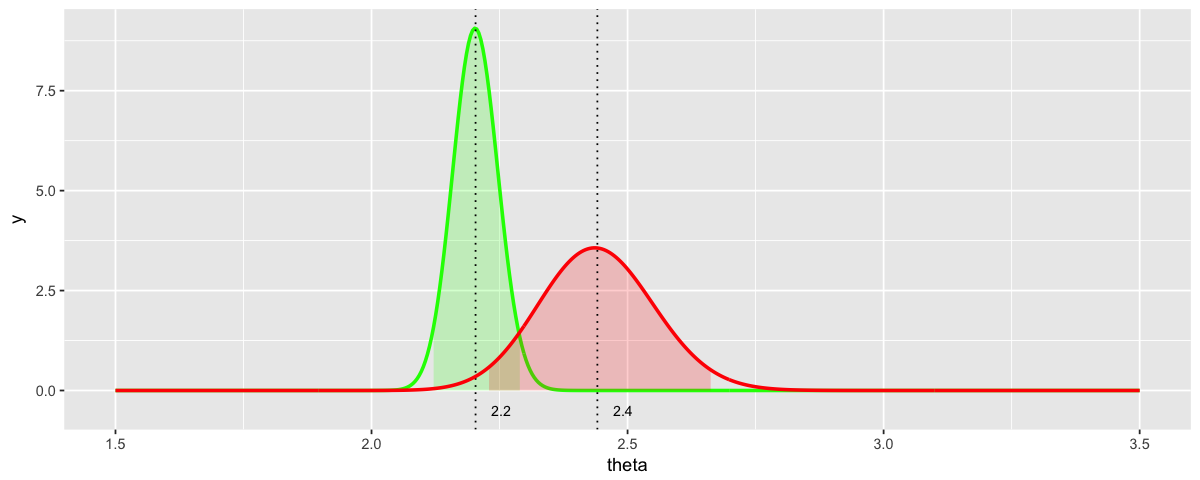

In [4]:
build_plot(2.2*100, 100, 2.2*100, 100)

[1] 0.9981


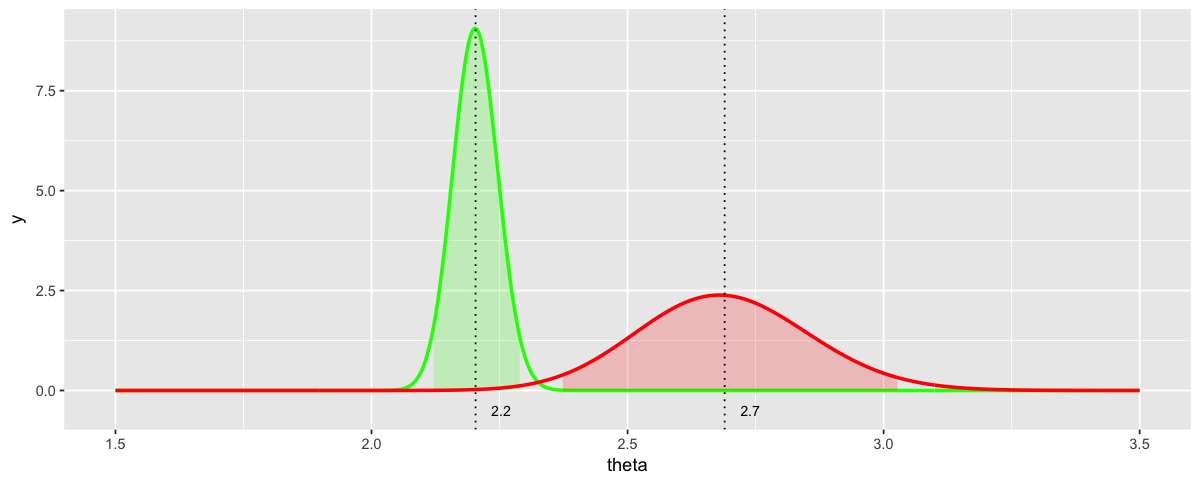

In [5]:
build_plot(2.2*100, 100, 2.2, 1)

[1] 0.9987


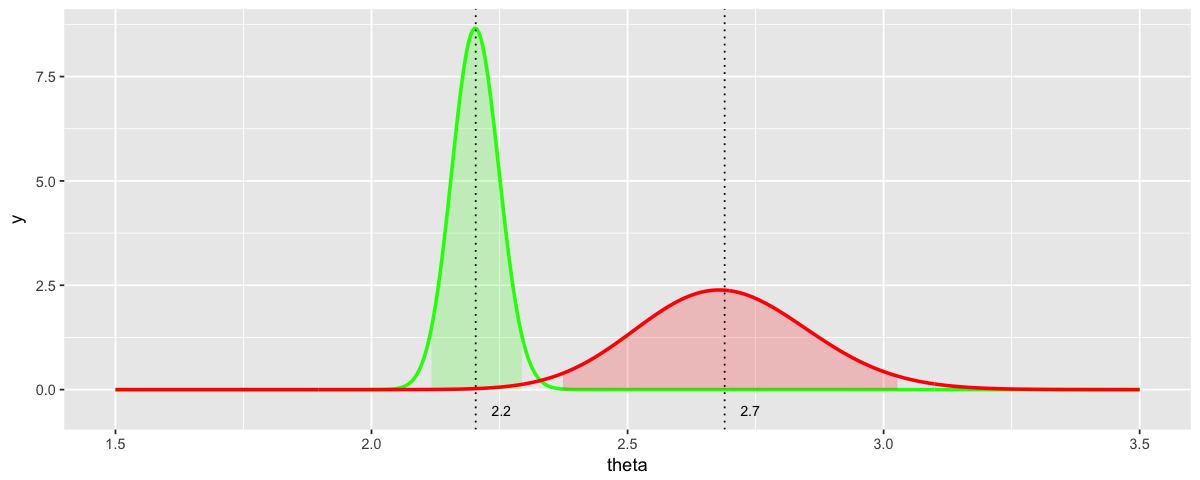

In [6]:
build_plot(2.2, 1, 2.2, 1)

##### Problem D

> d) In the above analysis we assumed that population size gives no information about fatality rate. Is this reasonable? How would the analysis have to change if this is not reasonable?

##### Problem E

> e) We encoded our beliefs about $\theta_1$ and $\theta_2$ such that they gave no information about each other (they were a priori independent). Think about why and how you might encode beliefs such that they were a priori dependent.

##### Solution

If $\theta_1$ and $\theta_2$ were dependent we would have a joint prior distribution $p(\theta_1, \theta_2)$ and posterior $p(\theta_1, \theta_2\ |\ data)$. Would it be [Matrix Gamma](https://en.wikipedia.org/wiki/Matrix_gamma_distribution)?